# Using Recurrent Neural Networks for Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import re, string

from sklearn.model_selection import train_test_split

%matplotlib inline

# A. Producing Word Embeddings

## 1. Load the data

In [2]:
reviews = pd.read_csv('data/Reviews.csv', usecols=['Score', 'Text'])
reviews.rename(columns=lambda x: x.lower(), inplace=True)

In [3]:
print(reviews['text'].iloc[0])

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


## 2. Some pre-processing

### Get rid of punctuations and upper case

In [4]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
reviews['text'] = reviews['text'].apply(lambda x: regex.sub('', x).lower())
## Shuffle the reviews
reviews = reviews.sample(frac=1, random_state=777).reset_index(drop=True)
reviews.head(10)

,score,text
0,5,great cereal a great price taste good even t...
1,5,put it on anything love it on anything thats p...
2,3,these are excellent chocolates just dont let t...
3,5,good price fast shipping good instructions wit...
4,4,i am obsessed with researching stuff and i was...
5,5,i bought this cappuccino because of the priceb...
6,5,these are great take a long time to ship and r...
7,5,i have been buying these for years from walmar...
8,4,this was my favorite comfort food as a child a...
9,5,its like a traditional mexican cocoa but insta...


### Keeping only first 50 words of the reviews

We are using only the first 50 words in every review, (sequences of length 50), those reviews with less that 50 words will be padded with vectors of zeros and longer reviews will be truncated.

In [5]:
max_words = 50
reviews['sequence'] = reviews['text'].apply(lambda x: x.split()[:max_words])

### Re-label reviews

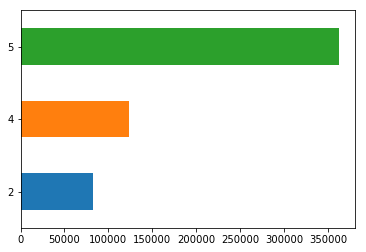

In [6]:
reviews.loc[reviews['score']==1,'score'] = 2
reviews.loc[reviews['score']==3,'score'] = 4
reviews['score'].value_counts(sort=False).plot(kind='barh');

In [7]:
reviews['score'].value_counts(sort=False, normalize=True)

2    0.144316
4    0.216895
5    0.638789
Name: score, dtype: float64

## 3. Getting training and testing subsets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(reviews['sequence'].values,
                                                    pd.get_dummies(reviews['score']).values, # one-hot encoding
                                                    test_size=0.05, random_state=123)

## 4. Producing word embedings

Important parameters

1. Vocabulary size
1. Window
1. Embedding dimension

Install the gensim library:

`conda install -c anaconda gensim`

In [9]:
from gensim.models.word2vec import Word2Vec

C:\Users\direc\Anaconda3\envs\recipes-ai\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [10]:
max_vocabulary_size = 3000
embedding_dim = 50
min_count = 5

model = Word2Vec(size=embedding_dim,
                 window=6,
                 min_count=min_count,
                 max_vocab_size=max_vocabulary_size)
model.build_vocab(X_train)
model.train(sentences=X_train, total_examples=model.corpus_count, epochs=10)

(125068487, 226945120)

In [11]:
model.wv['product']

array([-1.91803992, -2.44036102, -3.49612331, -0.92471123,  1.0321672 ,
        2.66399598, -1.93754029,  4.74564362,  1.00914228,  0.95863259,
        1.31733918, -1.59876704,  0.81256729,  1.33300054,  3.31886506,
        0.69455218, -2.00803733,  1.76593316,  3.29307652, -2.06365609,
        0.36898309, -0.47447032, -2.41572547,  2.77821445, -4.18435001,
        0.58786094, -0.55224586,  1.18403113,  0.60682547,  1.05824172,
        4.43394995,  1.09848392, -3.27739215,  2.98259044,  1.46257973,
        1.64573169,  0.09466935, -0.8062306 , -2.01446009,  2.55797005,
        0.10935304,  3.00712371, -0.80702281,  3.06787491,  1.88474381,
       -0.41363949, -3.91767955, -4.73285341, -1.53697217, -4.57130527], dtype=float32)

In [12]:
model.wv.most_similar(positive=['great'])

[('fantastic', 0.8739721775054932),
 ('wonderful', 0.8125402927398682),
 ('awesome', 0.7705838084220886),
 ('perfect', 0.7591169476509094),
 ('good', 0.7415000200271606),
 ('amazing', 0.6989656686782837),
 ('excellent', 0.696956992149353),
 ('nice', 0.6343750357627869),
 ('reasonable', 0.6248853206634521),
 ('delicious', 0.596721351146698)]

In [13]:
model.wv.most_similar(negative=['disappointed'])

[('keeps', 0.39703893661499023),
 ('makes', 0.38137316703796387),
 ('without', 0.3775547742843628),
 ('takes', 0.3626345098018646),
 ('youre', 0.3588273525238037),
 ('everyday', 0.3581927418708801),
 ('keep', 0.35073983669281006),
 ('kids', 0.32740432024002075),
 ('meals', 0.31569379568099976),
 ('veggies', 0.3051527142524719)]

In [14]:
model.wv.most_similar(positive=['bad'])

[('ok', 0.7417405843734741),
 ('terrible', 0.7382642030715942),
 ('good', 0.6568938493728638),
 ('bland', 0.5921519994735718),
 ('weak', 0.5737581849098206),
 ('fine', 0.5590717792510986),
 ('cheap', 0.5342099070549011),
 ('maybe', 0.5301104784011841),
 ('bitter', 0.5171574950218201),
 ('salty', 0.4717325270175934)]

In [15]:
print("Number of words considered in the model: ", len(model.wv.vocab))

Number of words considered in the model:  944


## 5. Prepare embedings for modelling

Going from a sequence of words to a sequence of vectors.

In [16]:
embedding_array_train = np.zeros(shape=(X_train.shape[0], max_words, embedding_dim))
for i, review in enumerate(X_train):
    for j, word in enumerate(review):
        if word in model.wv.vocab:
            embedding_array_train[i, j] = model.wv[word]
            
embedding_array_train = embedding_array_train.astype(np.float16)

In [17]:
embedding_array_train[0].shape

(50, 50)

In [18]:
embedding_array_train[0]

array([[  3.31250000e+00,   4.17578125e+00,  -2.99414062e+00, ...,
          1.66796875e+00,  -3.60107422e-01,  -1.73535156e+00],
       [  3.77929688e+00,  -5.30078125e+00,   2.96484375e+00, ...,
          1.16406250e+00,   3.01757812e-01,  -3.02343750e+00],
       [ -1.36816406e+00,   2.95898438e+00,  -1.72265625e+00, ...,
         -1.00781250e+00,  -1.05175781e+00,  -9.92187500e-01],
       ..., 
       [ -3.32031250e-01,  -5.81250000e+00,  -1.59960938e+00, ...,
         -1.37207031e+00,   1.89062500e+00,   4.02587891e-01],
       [ -3.42968750e+00,  -1.47070312e+00,   1.49154663e-03, ...,
          8.66699219e-01,   3.00585938e+00,   2.04492188e+00],
       [  2.60351562e+00,  -3.63671875e+00,   1.17578125e+00, ...,
          2.93457031e-01,  -5.39550781e-02,  -1.06750488e-01]], dtype=float16)

In [19]:
embedding_array_test = np.zeros(shape=(X_test.shape[0], max_words, embedding_dim))
for i, review in enumerate(X_test):
    for j, word in enumerate(review):
        if word in model.wv.vocab:
            embedding_array_test[i, j] = model.wv[word]
            
embedding_array_test = embedding_array_test.astype(np.float16)

# B. Predicting type of review using LSTM Networks

## 1. Building the input pipeline

In [20]:
#tf.reset_default_graph()

In [21]:
batch_size = 128

X_train_ph = tf.placeholder(tf.float16, shape=embedding_array_train.shape)
y_train_ph = tf.placeholder(tf.int32, shape=y_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_ph, y_train_ph))
train_dataset = train_dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
iterator = train_dataset.make_initializable_iterator()
next_element = iterator.get_next()

## 2. Create placeholders to pass values

In [22]:
## Placeholders
n_categories = y_train.shape[1] ## n_categories=3

X = tf.placeholder(tf.float16, shape=[None, max_words, embedding_dim])
y = tf.placeholder(tf.int32, shape=[None, n_categories])

## 3. Creating a LSTM network

In [23]:
def RNN(X):
    units_in_cells = [200, 32]
    rnn_layers = [tf.nn.rnn_cell.LSTMCell(size, activation=tf.nn.tanh, use_peepholes=True) for size in units_in_cells]
    multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(multi_rnn_cell, X, dtype=tf.float16)
    ## Additional dense layers before getting the logits
    dense_1 = tf.layers.dense(inputs=rnn_outputs[:, -1, :], units=32, activation=tf.nn.relu)
    dense_2 = tf.layers.dense(inputs=dense_1, units=16, activation=tf.nn.relu)
    logits = tf.layers.dense(inputs=dense_2, units=n_categories, activation=None)
    return logits

## 4. Getting the predictions

In [24]:
# Predicted probabilities:
logits = RNN(X)
y_pred_prob = tf.nn.softmax(logits)
# Predicted category:
y_pred = tf.cast(tf.argmax(y_pred_prob, axis=1), tf.int32)
y_labels = tf.argmax(y, axis=1)
accuracy, accuracy_update_op = tf.metrics.accuracy(labels=y_labels, predictions=y_pred)

## 5. Calculate the loss and training operation

In [25]:
learning_rate = 0.001/3
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

## Train the model

In [26]:
saver = tf.train.Saver()

In [27]:
def train_model():
    iterator.initializer.run(feed_dict={X_train_ph:embedding_array_train, y_train_ph:y_train})
    tf.local_variables_initializer().run()
    while True:
        try:
            X_values, y_values = sess.run(next_element)
            train_acc, _, _ = sess.run([accuracy, accuracy_update_op, training_op], feed_dict={X: X_values, y:y_values})
        except tf.errors.OutOfRangeError:
            break
    ## Testing accuracy:
    test_logits = sess.run(logits, feed_dict={X: embedding_array_test})
    exp_logits = np.exp(test_logits)
    y_test_pred_prob = exp_logits / exp_logits.sum(axis=1).reshape(-1,1)
    y_test_pred = y_test_pred_prob.argmax(axis=1)
    test_acc = (y_test_pred == y_test.argmax(axis=1)).mean()
    return train_acc, test_acc

In [28]:
n_epochs = 15
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        train_acc, test_acc = train_model()
        print('Epoch: {}, Train accuracy: {:0.3f}, Test accuracy: {:0.3f}'.format(epoch+1, train_acc, test_acc))
    print("Done training")
    save_path = saver.save(sess, "./SavedModels/reviews-rnn.ckpt")
    test_pred = sess.run(y_pred, feed_dict={X: embedding_array_test})

Epoch: 1, Train accuracy: 0.708, Test accuracy: 0.736
Epoch: 2, Train accuracy: 0.755, Test accuracy: 0.755
Epoch: 3, Train accuracy: 0.775, Test accuracy: 0.765
Epoch: 4, Train accuracy: 0.790, Test accuracy: 0.778
Epoch: 5, Train accuracy: 0.804, Test accuracy: 0.782
Epoch: 6, Train accuracy: 0.817, Test accuracy: 0.790
Epoch: 7, Train accuracy: 0.829, Test accuracy: 0.798
Epoch: 8, Train accuracy: 0.839, Test accuracy: 0.800
Epoch: 9, Train accuracy: 0.848, Test accuracy: 0.803
Epoch: 10, Train accuracy: 0.856, Test accuracy: 0.804
Epoch: 11, Train accuracy: 0.863, Test accuracy: 0.808
Epoch: 12, Train accuracy: 0.869, Test accuracy: 0.807
Epoch: 13, Train accuracy: 0.875, Test accuracy: 0.810
Epoch: 14, Train accuracy: 0.880, Test accuracy: 0.809
Epoch: 15, Train accuracy: 0.884, Test accuracy: 0.810
Done training


In [41]:
incorrect = (test_pred != y_test.argmax(axis=1))
rev_index = 0
print("Prediction: ", test_pred[incorrect][rev_index])
print("Observed: ", y_test.argmax(axis=1)[incorrect][rev_index])    
for x in X_test[incorrect][0]:
    print(x, end=' ')

Prediction:  0
Observed:  2
my kids always want bourbon chicken when we go to food courts so i decided to do some research on recipes and found this item along with bourbon chicken marinade in the same line this sauce didnt disappoint us it tastes just like what we had at food courtsbr br 